# Windrad-Vogeltracking

## 120° Methode

In [1]:
#------------------------ Imports ------------------------#

import imutils
import cv2
import numpy as np

#------------------------ Video festlegen ------------------------#

Video = ["videos/Simulation1_Front.mp4",(962,548),200,20]

#------------------------ Videoparameter festlegen ------------------------#

vs = cv2.VideoCapture(Video[0])
center = Video[1]
rotor_radius = Video[2]
hub_circle_radius = Video[3]

#------------------------ Algorithmus ------------------------#

old = None 
for i in range(0,int(vs.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = vs.read()                                   # Bild aus Video einlesen
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)           # Bild zu grau konvertieren
    gray = cv2.GaussianBlur(gray, (21, 21), 0)               # Bild blurren
        
    if old is None:                                          # Erstes Bild initialisieren
        old = gray                                           #
        continue                                             #
        
    frameDelta = cv2.absdiff(old, gray)                                                   # Differenz (Delta) zwischen altem und neuem Bild berechnen
    thresh = cv2.threshold(frameDelta, 5, 255, cv2.THRESH_BINARY)[1]                      # Delta threshholde
    thresh = cv2.dilate(thresh, None, iterations=2)                                       #
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    # Alle zusammenhängenden Konturen erkennen
    cnts = imutils.grab_contours(cnts)                                                    #
    
    for c in cnts:                                                       # Für jede Kontur...
        line_image = np.zeros(frame.shape[:-1])                          # Neues leeres Bild mit gleicher Größe erstellen (Für spätere Berechnungen)
    
        distances = [np.linalg.norm(center-i[0]) for i in c]             # Distanzen aller Punkte der Kontur zum Center berechnen
        point = c[np.argsort(distances)[-1]][0]                          # Punkt mit größter Distanz ermitteln
        distance = np.sort(distances)[-1]                                # Distanz dieses Punktes ermitteln
    
        z = (complex(point[0],point[1]) - complex(center[0],center[1])) * (-0.4999999999999998-0.8660254037844387j) + complex(center[0],center[1])     # Punkt der um 120° angewinkelte Linie berechnen
        angled_point_coords = np.int32([z.real,z.imag])                                                                                                #
        
        cv2.line(line_image, angled_point_coords, center, (255,255,255), 25)              # Angewinkelte Linie auf leeres Bild einzeichnen
        cv2.line(frame, angled_point_coords, center, (255,255,255), 25)                  # Diese Linie anzeigen (optional)
        
        #cv2.putText(frame,str(distance),point,cv2.FONT_HERSHEY_COMPLEX,1,(0,163,255),2)  # Distanz anzeigen (optional)
        
        if (distance < rotor_radius and np.sum(np.int32(line_image) & thresh) > 100000) or distance < hub_circle_radius:       # Wenn Punkt zwischen im Rotorbereich ist, und Angewinkelte Linie 
                cv2.line(frame, point, center, (0,0,255), 2)                                                                 # mehr als 1000 Pixel von anderen Konturen überdeckt, gehört Kontur zum Rotor
        else:
            cv2.line(frame, point, center, (255,0,0), 2)                                                                     # Andernfalls Vogel -> Blaue Linie + Kreis
            cv2.circle(frame, point, 10, (255,0,0), 2)
    
    old = gray   #Setze old auf aktuelles Bild, um es im nächsten Durchlauf zu vergleichen
    
#------------------------ Anzeigen ------------------------#

    cv2.circle(frame, center, rotor_radius, (0, 255, 255), 2)          # Kreise einzeichnen
    cv2.circle(frame, center, hub_circle_radius, (0, 0, 0), 2)         #
    cv2.circle(frame, center, 2, (255, 0, 255), 2)                     #
    
    cv2.imshow("Frame", frame)
    #cv2.imshow("line", line_image)
    cv2.imshow("Thresh", thresh)
    #cv2.imshow("Frame Delta", frameDelta)
    key = cv2.waitKey(1)
    if key == ord("q"):
        break
    if key == ord("p"):
        cv2.waitKey(-1)
        
cv2.destroyAllWindows()
vs.release()

## Windrad maskieren

In [2]:
#------------------------ Imports ------------------------#

import imutils
import cv2
import numpy as np

#------------------------ Video festlegen ------------------------#

Video = ["videos/Simulation1_Front.mp4",(962,548),200,20,48]

#------------------------ Videoparameter festlegen ------------------------#

vs = cv2.VideoCapture(Video[0])
center = Video[1]
rotor_radius = Video[2]
hub_circle_radius = Video[3]
img_count = Video[4]

#------------------------ Kreis fürs Rotor ausblenden ------------------------#

frames_per_rotation = 180
theta = np.linspace(0, -2*np.pi, num=frames_per_rotation) #180 Werte zwischen 0 und 2*pi
x = rotor_radius*np.sin(theta) # x-Koordinaten nach Einheitskreis
y = rotor_radius*np.cos(theta) # y-Koordinaten nach Einheitskreis
rotor_positions = [(int(x[i])+center[0],int(y[i])+center[1]) for i in range(frames_per_rotation)]

#------------------------ Variablen ------------------------#

old = None

#------------------------ Algorithmus ------------------------#

for i in range(0,int(vs.get(cv2.CAP_PROP_FRAME_COUNT))):
    img_count = (img_count+1)%frames_per_rotation            # Counter hochzählen (maximal 180)
    ret, frame = vs.read()                                   # Bild aus Video einlesen
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)           # Bild zu grau konvertieren
    gray = cv2.GaussianBlur(gray, (21, 21), 0)               # Bild blurren
        
    if old is None:                                          # Erstes Bild initialisieren
        old = gray                                           #
        continue                                             #
    
    line_image = np.zeros(frame.shape[:-1])                  # Neues leeres Bild mit gleicher Größe erstellen (Für spätere Berechnungen)
    for i in range(0,frames_per_rotation,frames_per_rotation//3):
        pos = rotor_positions[(img_count+i)%frames_per_rotation]
        cv2.line(line_image, pos, center, (255,255,255), 65)              # Angewinkelte Linie auf leeres Bild einzeichnen
        #cv2.line(frame, pos, center, (255,255,255), 65)                  # Diese Linie auch auf frame anzeigen (optional)
    
    
    frameDelta = cv2.absdiff(old, gray)                                                   # Differenz (Delta) zwischen altem und neuem Bild berechnen
    thresh = cv2.threshold(frameDelta, 10, 255, cv2.THRESH_BINARY)[1]                      # Delta threshholde
    thresh = cv2.dilate(thresh, None, iterations=4)                                       #
    thresh = thresh - np.uint8(line_image)
    thresh = cv2.threshold(thresh, 120, 255, cv2.THRESH_BINARY)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    # Alle zusammenhängenden Konturen erkennen
    cnts = imutils.grab_contours(cnts)                                                    #
    
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        tl = (x, y)
        br = (x+w, y+h)
        mid = (x+w//2,y+h//2)
        cv2.circle(frame, mid, 10, (255,0,0), 2)
    
    old = gray   #Setze old auf aktuelles Bild, um es im nächsten Durchlauf zu vergleichen
    
#------------------------ Anzeigen ------------------------#

    cv2.circle(frame, center, rotor_radius, (0, 255, 255), 2)          # Kreise einzeichnen
    cv2.circle(frame, center, hub_circle_radius, (0, 0, 0), 2)         #
    cv2.circle(frame, center, 2, (255, 0, 255), 2)                     #
    
    cv2.imshow("Frame", frame)
    cv2.imshow("line", line_image)
    cv2.imshow("Thresh", thresh)
    #cv2.imshow("Frame Delta", frameDelta)
    key = cv2.waitKey(1)
    if key == ord("q"):
        break
    if key == ord("p"):
        cv2.waitKey(-1)
        
cv2.destroyAllWindows()
vs.release()

## 2D-Tracking (Frontal)

In [4]:
#------------------------ Imports ------------------------#

import imutils
import cv2
import numpy as np
import matplotlib.pyplot as plt

#------------------------ Video festlegen ------------------------#

Video = ["videos/Simulation3_Front.mp4",(962,548),200,46]

#------------------------ Videoparameter festlegen ------------------------#
vs = cv2.VideoCapture(Video[0])
center = Video[1]
rotor_radius = Video[2]
img_count = Video[3]

#------------------------ Kreis fürs Rotor ausblenden ------------------------#

frames_per_rotation = 180
theta = np.linspace(0, -2*np.pi, num=frames_per_rotation) #180 Werte zwischen 0 und 2*pi
x = rotor_radius*np.sin(theta) # x-Koordinaten nach Einheitskreis
y = rotor_radius*np.cos(theta) # y-Koordinaten nach Einheitskreis
rotor_positions = [(int(x[i])+center[0],int(y[i])+center[1]) for i in range(frames_per_rotation)]

#------------------------ Variablen ------------------------#

frame_old = None
old_mids = []
birds = {0:[np.array((0,0))]}

#------------------------ Algorithmus ------------------------#

for i in range(0,int(vs.get(cv2.CAP_PROP_FRAME_COUNT))):
    img_count = (img_count+1)%frames_per_rotation            # Counter hochzählen (maximal 180)
    ret, frame = vs.read()                                   # Bild aus Video einlesen
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)           # Bild zu grau konvertieren
    gray = cv2.GaussianBlur(gray, (21, 21), 0)               # Bild blurren
        
    if frame_old is None:                                          # Erstes Bild initialisieren
        frame_old = gray                                           #
        continue                                             #
    
    line_image = np.zeros(frame.shape[:-1])                  # Neues leeres Bild mit gleicher Größe erstellen (Für spätere Berechnungen)
    for i in range(0,frames_per_rotation,frames_per_rotation//3):
        pos = rotor_positions[(img_count+i)%frames_per_rotation]
        cv2.line(line_image, pos, center, (255,255,255), 65)              # Angewinkelte Linie auf leeres Bild einzeichnen
        #cv2.line(frame, pos, center, (255,255,255), 65)                  # Diese Linie auch auf frame anzeigen (optional)
    
    
    frameDelta = cv2.absdiff(frame_old, gray)                                                   # Differenz (Delta) zwischen altem und neuem Bild berechnen
    thresh = cv2.threshold(frameDelta, 10, 255, cv2.THRESH_BINARY)[1]                      # Delta threshholde
    thresh = cv2.dilate(thresh, None, iterations=4)                                       #
    thresh = thresh - np.uint8(line_image)
    thresh = cv2.threshold(thresh, 120, 255, cv2.THRESH_BINARY)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    # Alle zusammenhängenden Konturen erkennen
    cnts = imutils.grab_contours(cnts)                                                    #
    
    current_mids = []                                      # Neue leere Liste für die Mittelpunkte
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        mid = np.array((x+w//2,y+h//2))
        cv2.circle(frame, mid, 50, (255,0,0), 1)
        cv2.circle(frame, mid, 5, (255,255,0), 1)
        
        current_mids.append(mid)                          # Alle Konturmittelpunkte werden der neuen Liste hinzugefügt
    
    for i in current_mids:
        d=[np.linalg.norm(i-j) for j in old_mids if list(j)!=list(i)] # Distanzen von Punkt i aus dem aktuellen Frame zu allen anderen Punkten aus dem letzten Frame
        # Punkt i muss dem Vogel zugeordnet werden, der min(d) hat, oder neuer Vogel muss erstellt werden.
        if d:
            if min(d) > 100:                       # Wenn der Mindestabstand des neuen Punkt zu allen alten Punkten über 100 ist, wird ein neuer Vogel angelegt
                birds[max(birds.keys())+1] = [i]
            else:                                                        # Ansonsten muss der die aktuelle Koordinate i einem bestehenden Vogel zugeordnet werden
                X = [birds[j][-1] for j in birds]
                d2=[np.linalg.norm(x-i) for x in X]
                mini = np.argsort(d2)[0]
                if mini < 100:
                    birds[mini].append(i)
                  
    
    frame_old = gray   #Setze old auf aktuelles Bild, um es im nächsten Durchlauf zu vergleichen
    old_mids = current_mids
    
    colors = [[48, 99, 225],[107, 250, 115],[103, 237, 251],[250, 166, 109],[173, 57, 170],[53, 41, 163],[187, 204, 53],[114, 225, 165],[251, 122, 78],[173, 62, 99]]
    for i in range(len(birds)):
        cv2.polylines(frame, [np.array(birds[i][1:-2])], 0, colors[i%10], 3)

#------------------------ Anzeigen ------------------------#

    cv2.circle(frame, center, rotor_radius, (0, 255, 255), 2)          # Kreise einzeichnen
    cv2.circle(frame, center, 2, (255, 0, 255), 2)                     #
    
    cv2.imshow("Frame", frame)
    #cv2.imshow("line", line_image)
    #cv2.imshow("Thresh", thresh)
    #cv2.imshow("Frame Delta", frameDelta)
    key = cv2.waitKey(1)
    if key == ord("q"):
        break
    if key == ord("p"):
        cv2.waitKey(-1)
del birds[0][0]
cv2.destroyAllWindows()
vs.release()

## 2D-Tracking (Seite)

In [8]:
#------------------------ Imports ------------------------#

import imutils
import cv2
import numpy as np
import matplotlib.pyplot as plt

#------------------------ Videos festlegen ------------------------#

Video = "videos/Simulation3_Side.mp4"

#------------------------ Videoparameter festlegen ------------------------#

vs = cv2.VideoCapture(Video)

#------------------------ Variablen ------------------------#

frame_old = None
old_mids = []
birds2 = {0:[np.array((0,0))]}

#------------------------ Algorithmus ------------------------#

for i in range(0,int(vs.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = vs.read()                                   # Bild aus Video einlesen
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)           # Bild zu grau konvertieren
    gray = cv2.GaussianBlur(gray, (21, 21), 0)               # Bild blurren
        
    if frame_old is None:                                          # Erstes Bild initialisieren
        frame_old = gray                                           #
        continue                                             #
    
    line_image = np.zeros(frame.shape[:-1])                  # Neues leeres Bild mit gleicher Größe erstellen (Für spätere Berechnungen)
    
    cv2.line(line_image, (955,400), (955,660), (255,255,255), 55)              # Angewinkelte Linie auf leeres Bild einzeichnen
    #cv2.line(frame, (955,400), (955,660), (255,255,255), 55)                  # Diese Linie auch auf frame anzeigen (optional)
    
    
    frameDelta = cv2.absdiff(frame_old, gray)                                                   # Differenz (Delta) zwischen altem und neuem Bild berechnen
    thresh = cv2.threshold(frameDelta, 10, 255, cv2.THRESH_BINARY)[1]                      # Delta threshholde
    thresh = cv2.dilate(thresh, None, iterations=4)                                       #
    thresh = thresh - np.uint8(line_image)
    thresh = cv2.threshold(thresh, 120, 255, cv2.THRESH_BINARY)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    # Alle zusammenhängenden Konturen erkennen
    cnts = imutils.grab_contours(cnts)                                                    #
    
    current_mids = []                                      # Neue leere Liste für die Mittelpunkte
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        mid = np.array((x+w//2,y+h//2))
        cv2.circle(frame, mid, 50, (255,0,0), 1)
        cv2.circle(frame, mid, 5, (255,255,0), 1)
        
        current_mids.append(mid)                          # Alle Konturmittelpunkte werden der neuen Liste hinzugefügt
    
    for i in current_mids:
        d=[np.linalg.norm(i-j) for j in old_mids if list(j)!=list(i)] # Distanzen von Punkt i aus dem aktuellen Frame zu allen anderen Punkten aus dem letzten Frame
        # Ab hier brainfuck:
        # Punkt i muss dem Vogel zugeordnet werden, der min(d) hat, oder neuer Vogel muss erstellt werden.
        if d:
            if min(d) > 100:                       # Wenn der Mindestabstand des neuen Punkt zu allen alten Punkten über 100 ist, wird ein neuer Vogel angelegt
                birds2[max(birds2.keys())+1] = [i]
            else:                                                        # Ansonsten muss der die aktuelle Koordinate i einem bestehenden Vogel zugeordnet werden
                X = [birds2[j][-1] for j in birds2]
                d2=[np.linalg.norm(x-i) for x in X]
                mini = np.argsort(d2)[0]
                if mini < 100:
                    birds2[mini].append(i)
                  
    
    frame_old = gray   #Setze old auf aktuelles Bild, um es im nächsten Durchlauf zu vergleichen
    old_mids = current_mids
    
    colors = [[48, 99, 225],[107, 250, 115],[103, 237, 251],[250, 166, 109],[173, 57, 170],[53, 41, 163],[187, 204, 53],[114, 225, 165],[251, 122, 78],[173, 62, 99]]
    for i in range(len(birds2)):
        cv2.polylines(frame, [np.array(birds2[i][1:-2])], 0, colors[i%10], 3)

#------------------------ Anzeigen ------------------------#
    
    cv2.imshow("Frame", frame)
    #cv2.imshow("line", line_image)
    #cv2.imshow("Thresh", thresh)
    #cv2.imshow("Frame Delta", frameDelta)
    key = cv2.waitKey(1)
    if key == ord("q"):
        break
    if key == ord("p"):
        cv2.waitKey(-1)
del birds2[0][0]
cv2.destroyAllWindows()
vs.release()

### Punkte im 3D Raum plotten

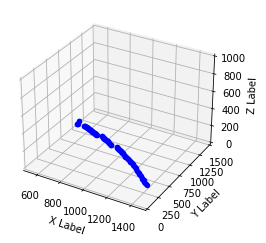

In [9]:
offset = 26
Coords = [(birds[0][i+offset][0],birds2[0][i][0],600-birds[0][i+offset][1]) for i in range(len(birds2[0]))]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for x,y,z in Coords:
    ax.scatter(x, y, z, color="blue")


ax.set_xlim3d([500, 1500])
ax.set_ylim3d([0, 1500])
ax.set_zlim3d([0, 1000])
    
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()